In [1]:
# import some things for convenience
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from enum import Enum

In [2]:
# Enum to better convey the semantics of the confidence precision (e.g., in the NINETIES as opposed to 91% or 95%)
class Confidence(Enum):
    HIGHNINETIES = 0
    NINETIES  = 1
    EIGHTIES  = 2

# create simple hist
def create_hist(x, mean, std):
    count, bins, ignored = plt.hist(x, 30, density=True)
    plt.plot(bins, 1/(std*np.sqrt(2*np.pi))*np.exp(-(bins-mean)**2/(2*std**2)), linewidth=2, color='r')
    plt.show()
    
def display_stats(name, x):
    print("=" * 20)
    print("Mean of {}: {}".format(name, np.mean(x)))
    print("STD of {}: {}".format(name, np.std(x)))
    print("Minimum {}: {}".format(name, np.min(x)))
    print("Maximum {}: {}".format(name, np.max(x)))

# ginarmous function that should be refactored but I'm too tired
def big_m(population, error, confidence=Confidence.NINETIES, initial_sample_size=10, max_sample_size=None, verbose=0):
    # ensure confidence is tempered for small samples
    if population.size < 80 and (confidence is Confidence.NINETIES or confidence is Confidence.HIGHNINETIES) :
        raise Exception("The confidence must be set to Confidence.EIGHTIES for samples of less than 80.")
        
    # init factors
    confidences = {Confidence.HIGHNINETIES:0.99, Confidence.NINETIES:0.95, Confidence.EIGHTIES:0.85}
    confidence_fraction = confidences[confidence]
    t = st.t.ppf(1-((1-confidence_fraction)/2), 1000000)
    consecutive_factor = np.log10(population.size)-np.log10(initial_sample_size)
    consecutive_count = 0
    consecutive_required = np.ceil((1/(1-confidence_fraction))*consecutive_factor)
    
    # keep the code from running excessively
    if max_sample_size is None:
        max_sample_size = min(initial_sample_size*20, population.size/2)
        
    # set up initial run
    sample = np.random.choice(population, initial_sample_size)
    sample_mean = np.mean(sample)
    ci_low = sample_mean-(t*(st.sem(sample, axis=None, ddof=1)))
    ci_high = sample_mean+(t*(st.sem(sample, axis=None, ddof=1)))

    # keep going until we find "enough" consecutive results that meet our expectations
    while consecutive_count < consecutive_required and sample.size < max_sample_size:
        if sample_mean - error < ci_low and sample_mean + error > ci_high:
            consecutive_count += 1
        else:
            consecutive_count = 0
        
        sample = np.append(sample, np.random.choice(population))
        sample_mean = np.mean(sample)
        ci_low = sample_mean-(t*(st.sem(sample, axis=None, ddof=1)))
        ci_high = sample_mean+(t*(st.sem(sample, axis=None, ddof=1)))  
    
    if verbose > 1:
        create_hist(sample, sample_mean, np.std(sample))
        print("Sample mean: {}".format(sample_mean))
    
    return sample_mean, sample.size, np.std(sample)

def test_100_samples(mean, std, size, error, confidence, max_sample_size, initial_sample_size=10, verbose=1):
    # create population
    population = np.random.normal(mean, std, size)# mean and standard deviation of men's heights
    actual_mean = np.mean(population)

    if verbose > 0:
        # histogram
        create_hist(population, mean, std)
        # display population stats
        display_stats("population", population)
    
    sample_means = np.array([])
    sample_sizes = np.array([])
    sample_stds = np.array([])
    
    for x in range(100):
        sample_mean, sample_size, sample_std = big_m(population, error, confidence=confidence, max_sample_size=max_sample_size, initial_sample_size=initial_sample_size, verbose=verbose)
        sample_means = np.append(sample_means, [sample_mean])
        sample_sizes = np.append(sample_sizes, [sample_size])
        sample_stds = np.append(sample_stds, [sample_std])
    
    if verbose > 0:
        display_stats("sample_means", sample_means)
        display_stats("sample_sizes", sample_sizes)
        display_stats("sample_stds", sample_stds)
    
    results = np.nonzero((sample_means > (actual_mean-error)) & (sample_means < actual_mean+error))
    if verbose > 0:
        print("=" * 20)
        print("Total samples falling within the range specified by the error: {}".format(results[0].size))
    return sample_means, sample_sizes, sample_stds

In [3]:
# init vars
mean = 70
std = 7

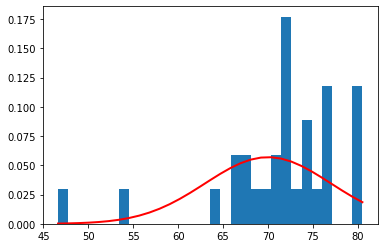

Mean of population: 71.43158432596485
STD of population: 7.102218791681626
Minimum population: 46.62828358662288
Maximum population: 80.50819872315108
Mean of sample_means: 71.5600256007595
STD of sample_means: 1.6562666404148434
Minimum sample_means: 66.52324058766045
Maximum sample_means: 75.8164642081091
Mean of sample_sizes: 14.35
STD of sample_sizes: 0.4769696007084728
Minimum sample_sizes: 14.0
Maximum sample_sizes: 15.0
Mean of sample_stds: 6.248476209328058
STD of sample_stds: 2.0511772109727
Minimum sample_stds: 2.382698033654554
Maximum sample_stds: 11.720989474160408
Total samples falling within the range specified by the error: 92


In [4]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 30, 3.5, Confidence.EIGHTIES, None)

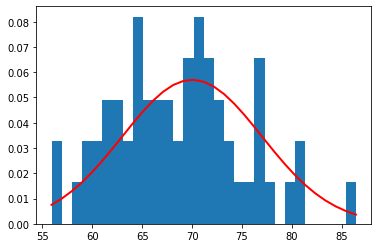

Mean of population: 68.65284794417268
STD of population: 6.411041725448435
Minimum population: 55.90915106899216
Maximum population: 86.4107877632051


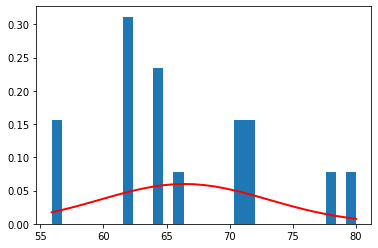

Sample mean: 66.41083162789073


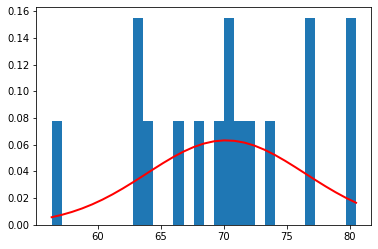

Sample mean: 70.16894310309635


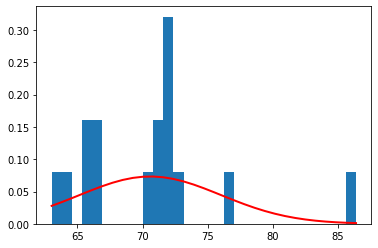

Sample mean: 70.59544777503257


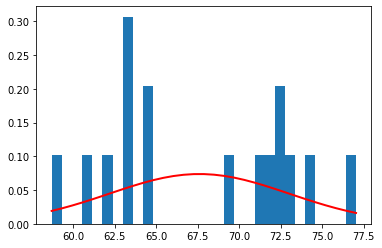

Sample mean: 67.5892632614211


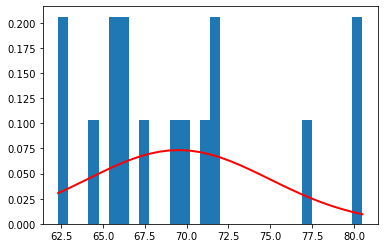

Sample mean: 69.5161875661608


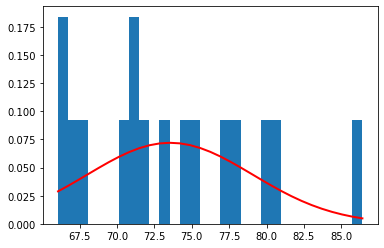

Sample mean: 73.54147463915774


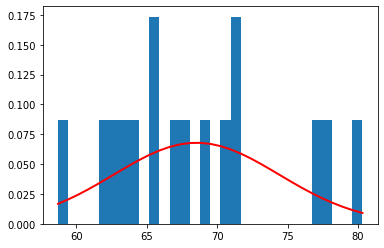

Sample mean: 68.53268718308483


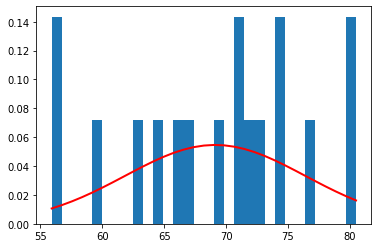

Sample mean: 69.12145482811312


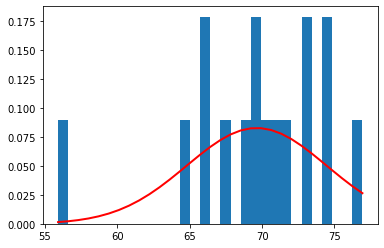

Sample mean: 69.62804654490932


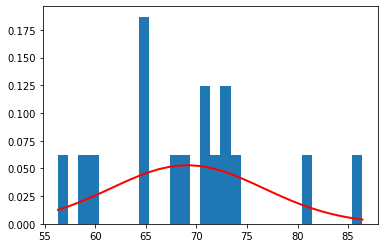

Sample mean: 69.10031563892346


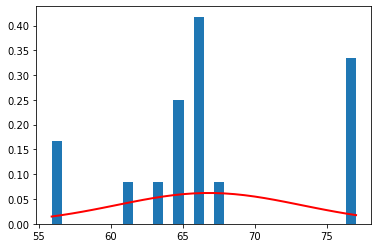

Sample mean: 66.8165443481366


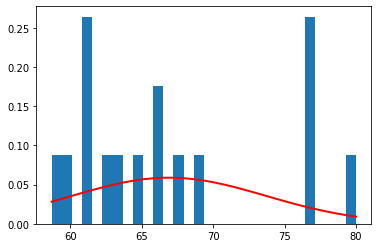

Sample mean: 66.90767958910101


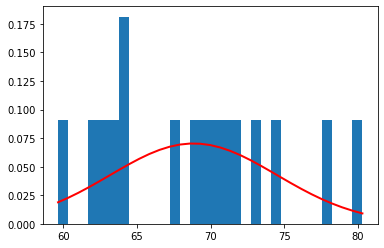

Sample mean: 68.84498641785736


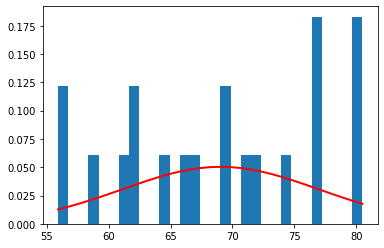

Sample mean: 69.04151368165148


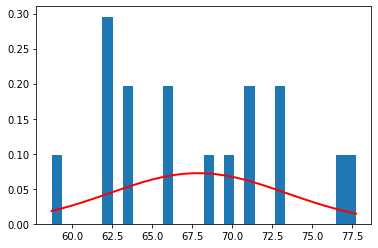

Sample mean: 67.85378719931444


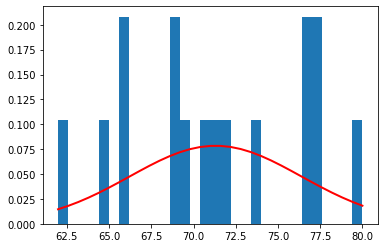

Sample mean: 71.30272858838431


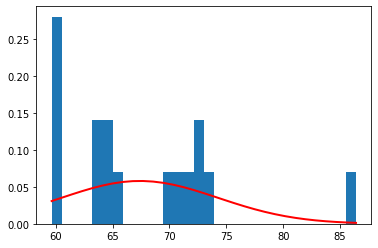

Sample mean: 67.38417623666166


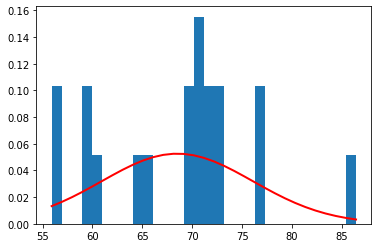

Sample mean: 68.5012480308284


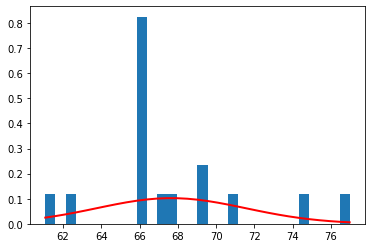

Sample mean: 67.65242625430552


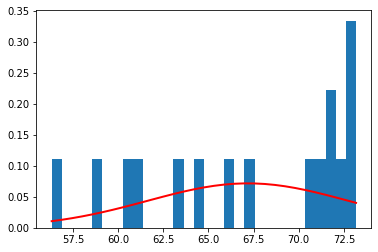

Sample mean: 67.18908631272244


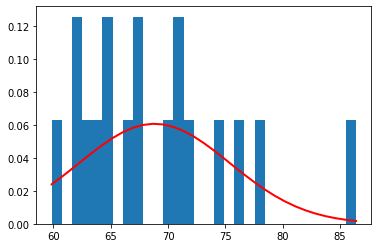

Sample mean: 68.81822286650645


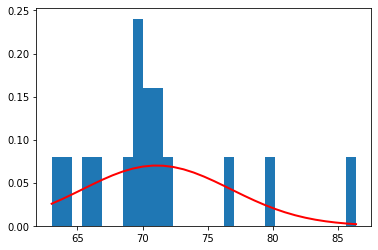

Sample mean: 71.09333301118457


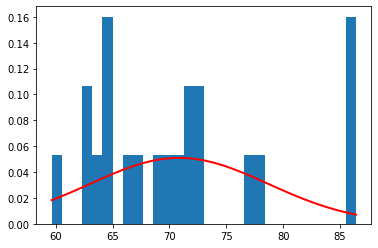

Sample mean: 70.8520671016922


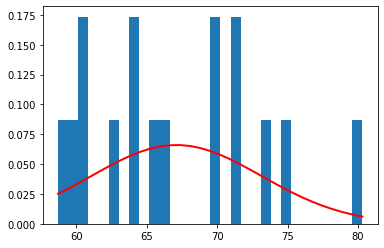

Sample mean: 67.10938336309744


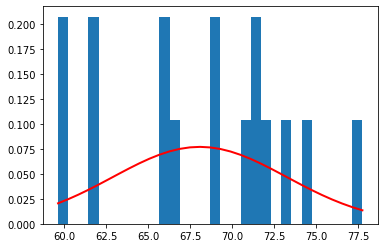

Sample mean: 68.06379181278993


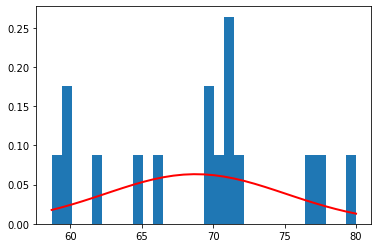

Sample mean: 68.76602054056838


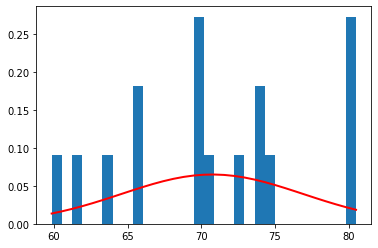

Sample mean: 70.74717670993957


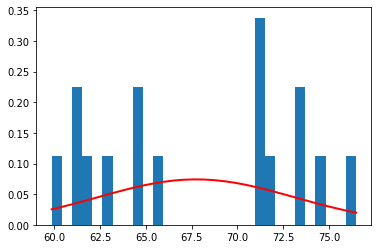

Sample mean: 67.74405145946608


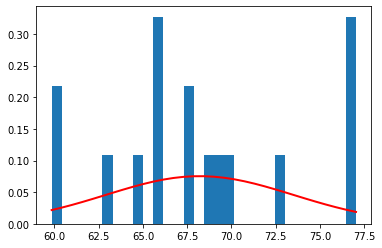

Sample mean: 68.20033586467156


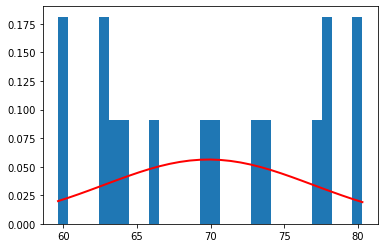

Sample mean: 69.86630002560612


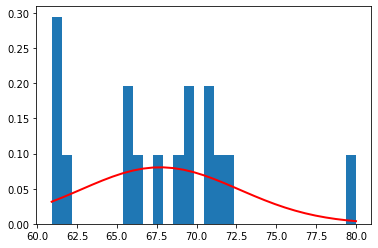

Sample mean: 67.71411764587364


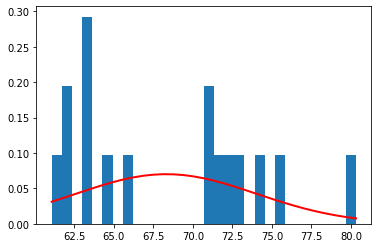

Sample mean: 68.32033921240654


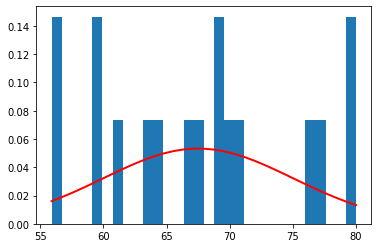

Sample mean: 67.50744240339993


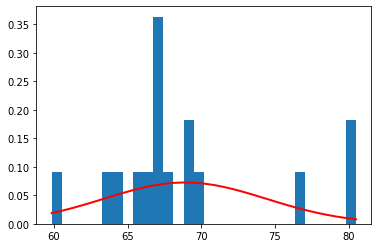

Sample mean: 68.89774441653867


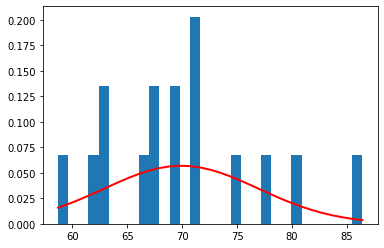

Sample mean: 69.9219576670286


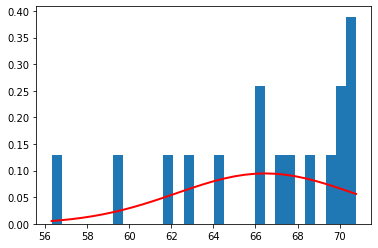

Sample mean: 66.45994630255309


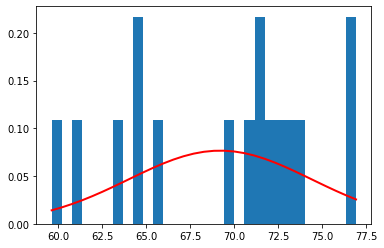

Sample mean: 69.2110070719661


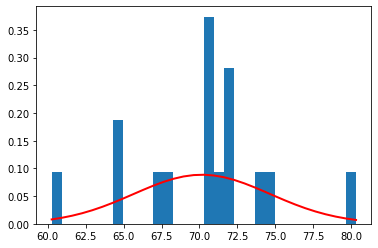

Sample mean: 70.15836222163345


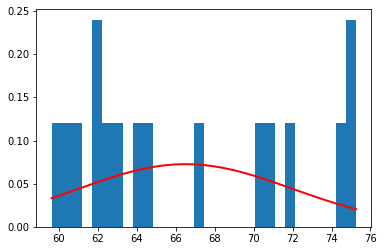

Sample mean: 66.50662662748903


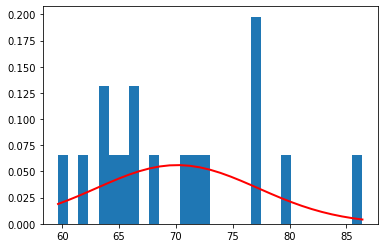

Sample mean: 70.12050881163645


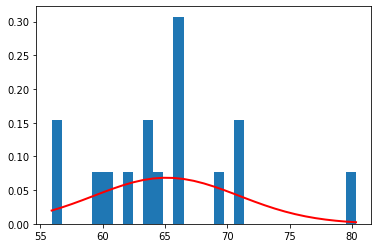

Sample mean: 65.11939273510856


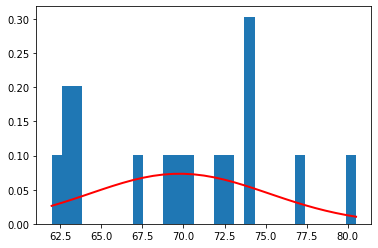

Sample mean: 69.75806835905574


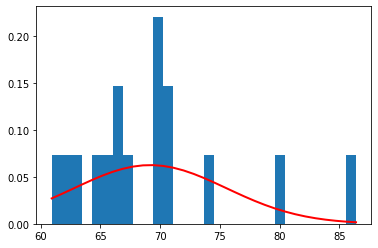

Sample mean: 69.17282928866297


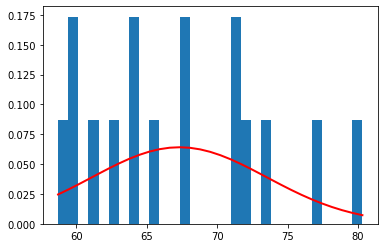

Sample mean: 67.31813312028706


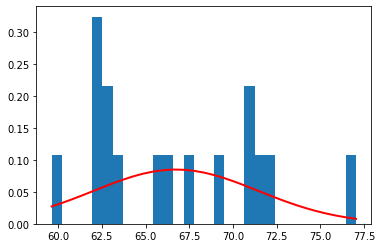

Sample mean: 66.73987150138039


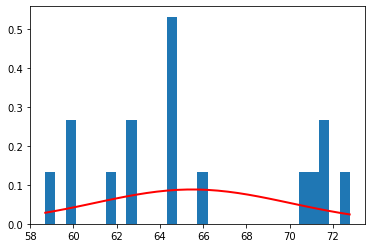

Sample mean: 65.49422910552565


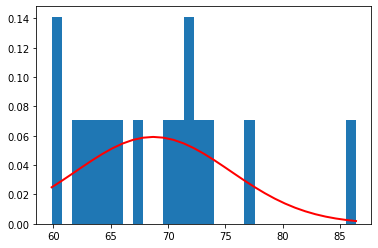

Sample mean: 68.71708616101844


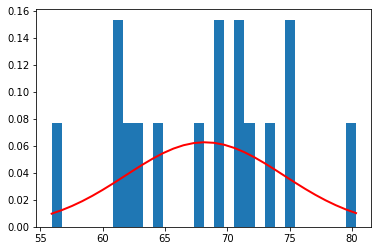

Sample mean: 68.1872473458262


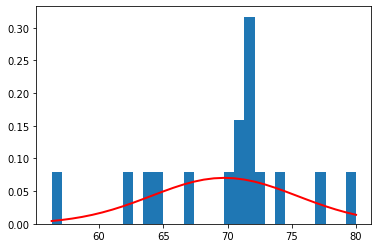

Sample mean: 69.7482454290006


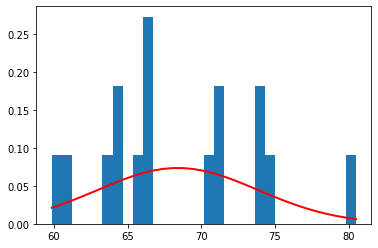

Sample mean: 68.40974351136447


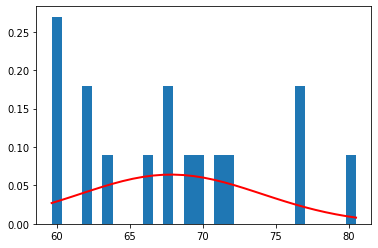

Sample mean: 67.8199051302739


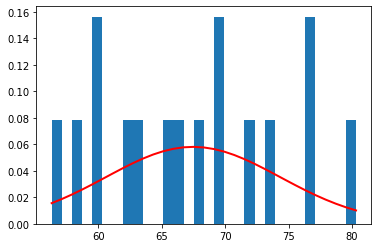

Sample mean: 67.46905907393624


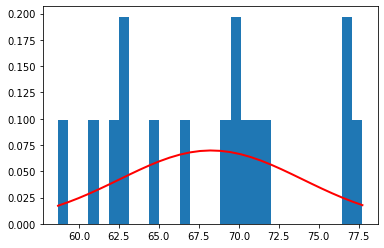

Sample mean: 68.26798153085839


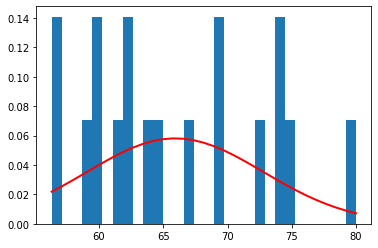

Sample mean: 65.929414728573


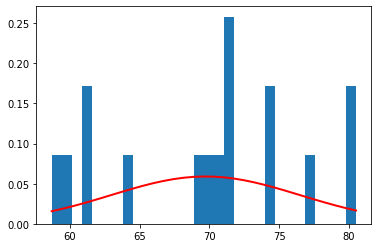

Sample mean: 69.72286443153169


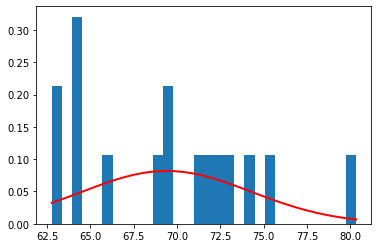

Sample mean: 69.39806834257465


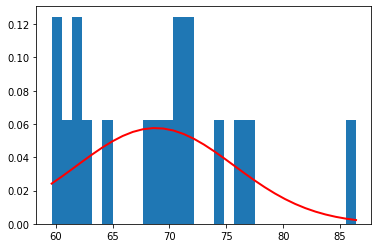

Sample mean: 68.76486815470771


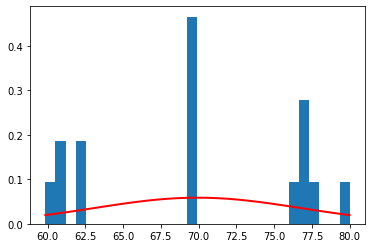

Sample mean: 69.92634037514884


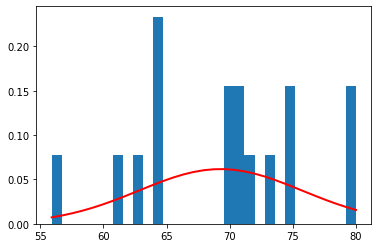

Sample mean: 69.27384859283998


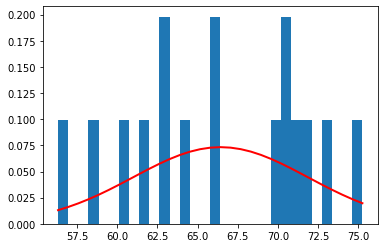

Sample mean: 66.43096300748991


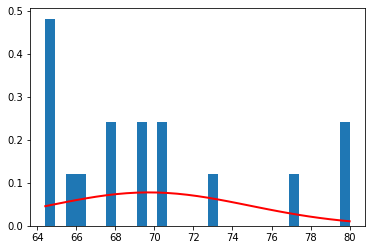

Sample mean: 69.71972649550332


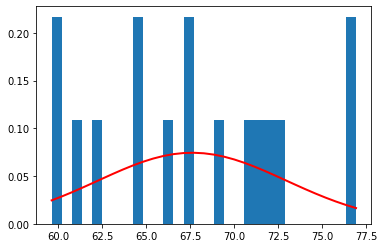

Sample mean: 67.61965963019361


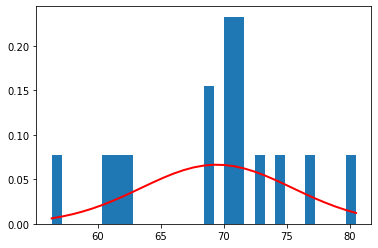

Sample mean: 69.44053096457682


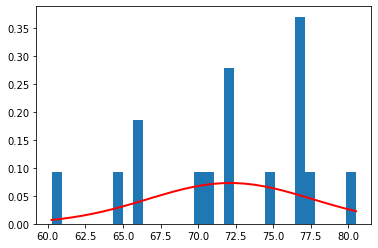

Sample mean: 72.12911171923241


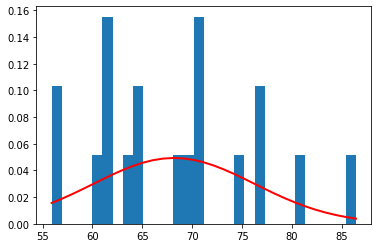

Sample mean: 68.1665326545512


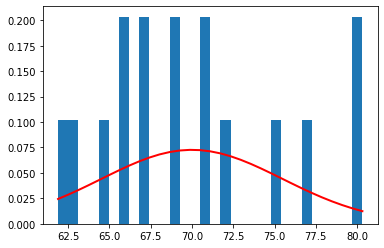

Sample mean: 69.99899867763118


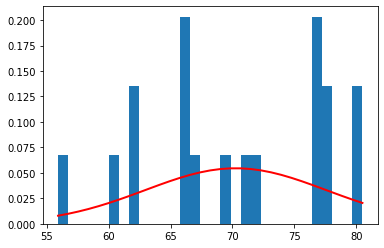

Sample mean: 70.2655532692192


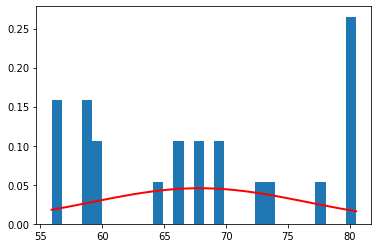

Sample mean: 67.85869838465021


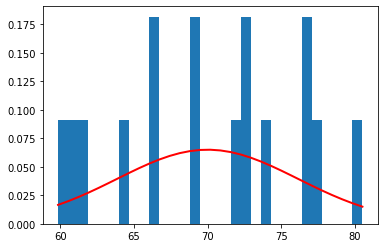

Sample mean: 69.99553639697292


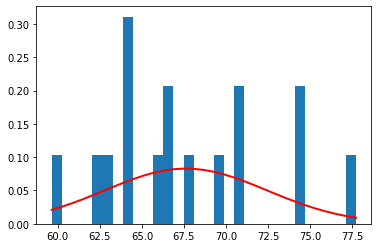

Sample mean: 67.61352055686582


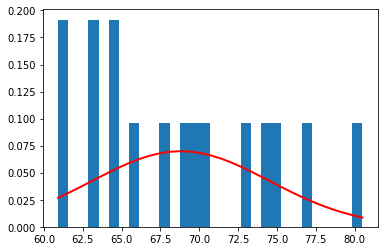

Sample mean: 68.81649932199515


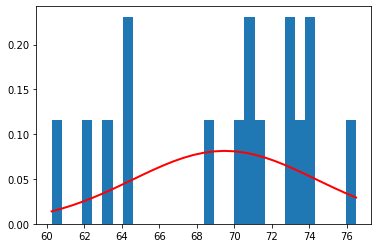

Sample mean: 69.48130784024121


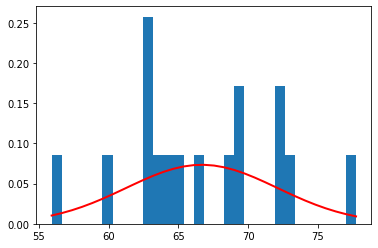

Sample mean: 66.67275319321192


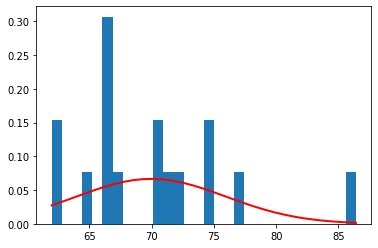

Sample mean: 69.96221143120434


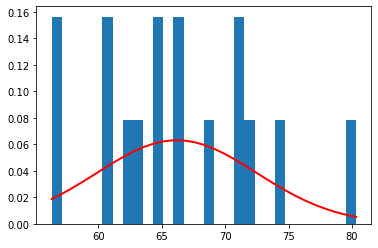

Sample mean: 66.18710010768461


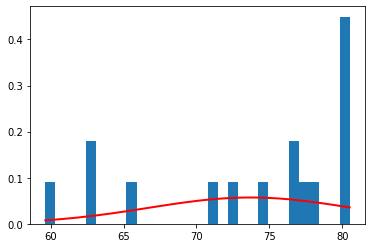

Sample mean: 73.6992780923963


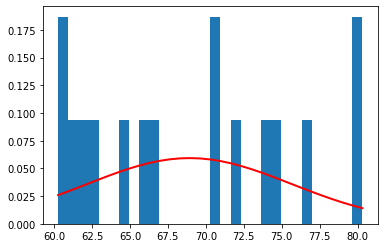

Sample mean: 68.91905419777174


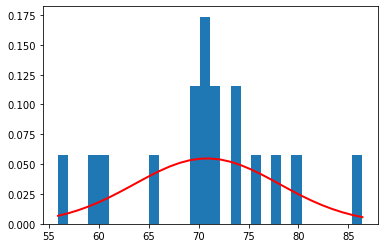

Sample mean: 70.83689009393638


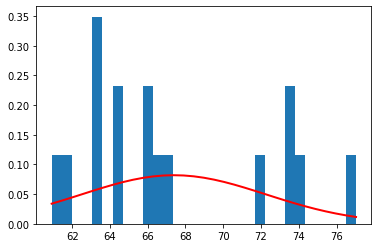

Sample mean: 67.3828082774622


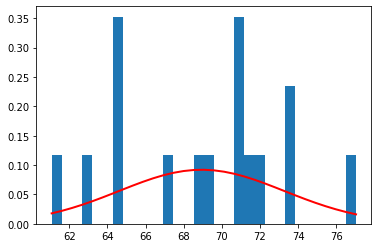

Sample mean: 68.93982265951644


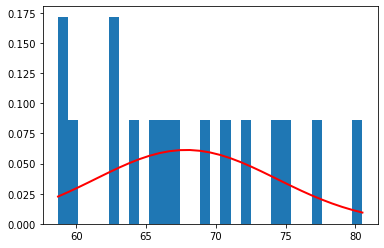

Sample mean: 67.88131640244063


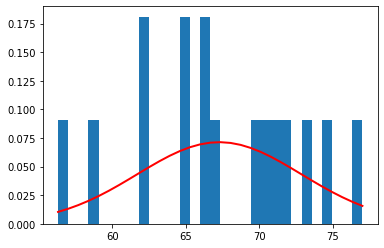

Sample mean: 67.29440264736922


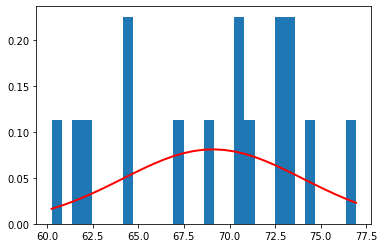

Sample mean: 69.08625837121286


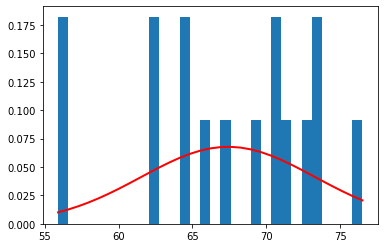

Sample mean: 67.40713660557964


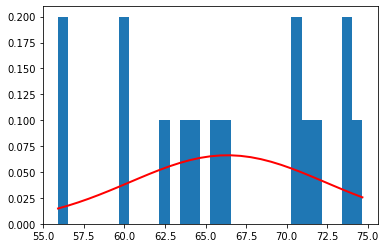

Sample mean: 66.35019117304557


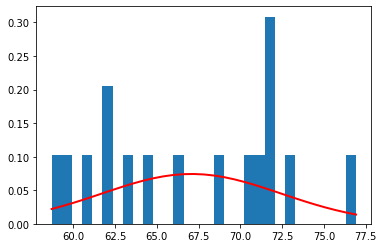

Sample mean: 67.07231520738512


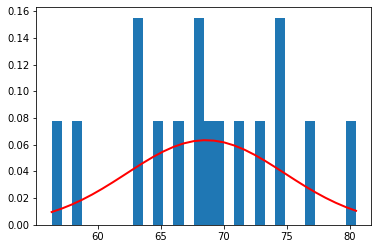

Sample mean: 68.56282150343995


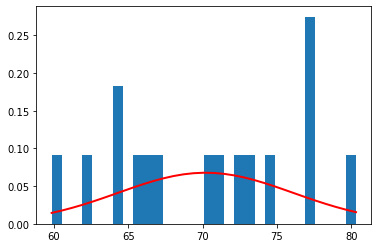

Sample mean: 70.20115588911173


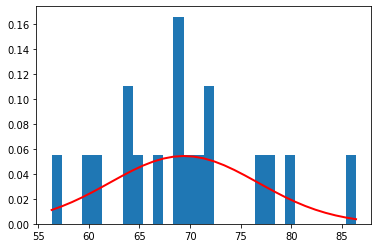

Sample mean: 69.39804509359469


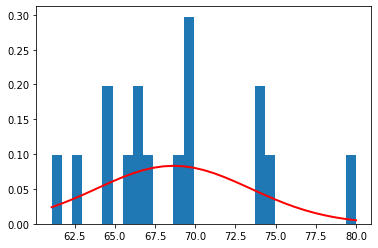

Sample mean: 68.65782425094326


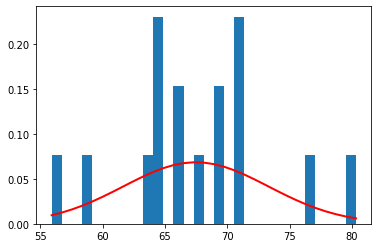

Sample mean: 67.4733241278417


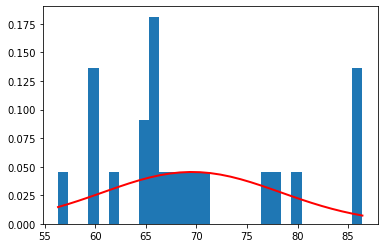

Sample mean: 69.54346810771231


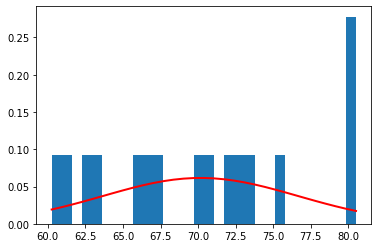

Sample mean: 70.15708587282839


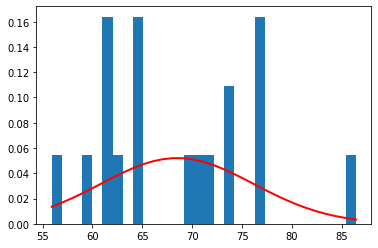

Sample mean: 68.4828535762545


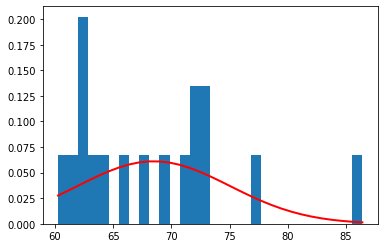

Sample mean: 68.48196670387573


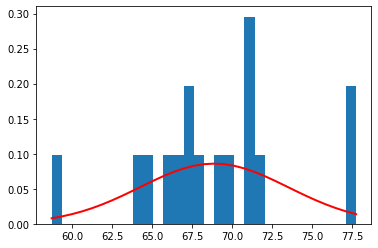

Sample mean: 68.85485020277812


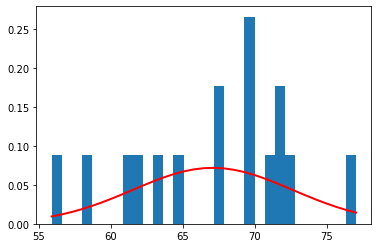

Sample mean: 67.08373370181556


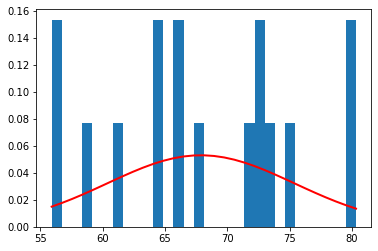

Sample mean: 67.87437905595623


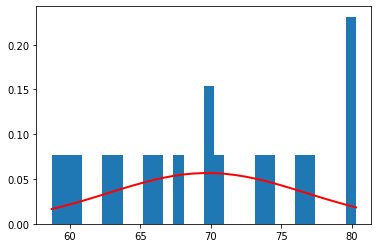

Sample mean: 69.75813245845691


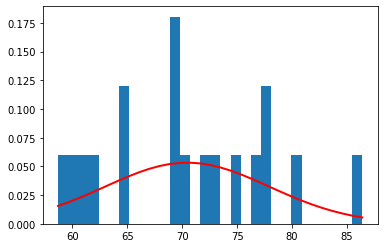

Sample mean: 70.45586221756642
Mean of sample_means: 68.67228441021992
STD of sample_means: 1.5477772613189809
Minimum sample_means: 65.11939273510856
Maximum sample_means: 73.6992780923963
Mean of sample_sizes: 16.5
STD of sample_sizes: 1.2529964086141667
Minimum sample_sizes: 16.0
Maximum sample_sizes: 23.0
Mean of sample_stds: 6.080105804222469
STD of sample_stds: 0.9987754445161405
Minimum sample_stds: 3.897874457895451
Maximum sample_stds: 8.79452950773322
Total samples falling within the range specified by the error: 97


In [5]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 60, 3.5, Confidence.EIGHTIES, None, verbose=2)

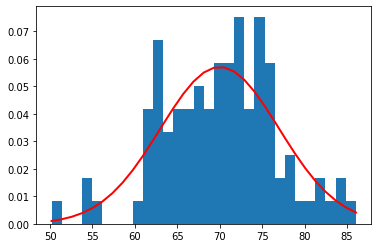

Mean of population: 69.9940445736199
STD of population: 6.706846911778507
Minimum population: 50.17356864708043
Maximum population: 86.05135735067432


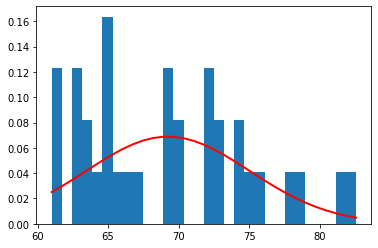

Sample mean: 69.24234507426269


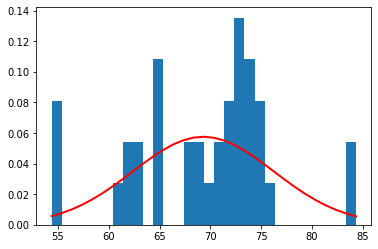

Sample mean: 69.31163827063357


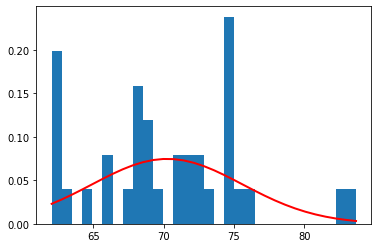

Sample mean: 70.25981036532572


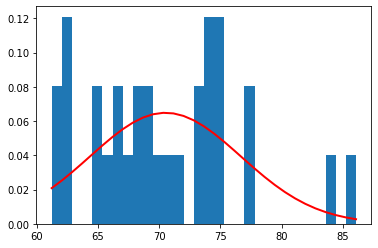

Sample mean: 70.51159776370875


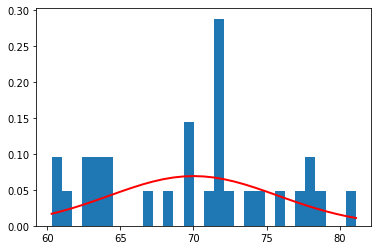

Sample mean: 70.01218308475968


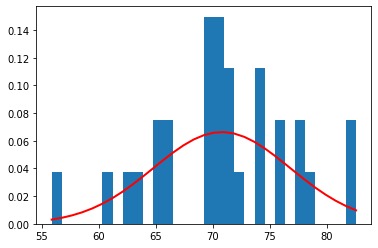

Sample mean: 70.79188463257938


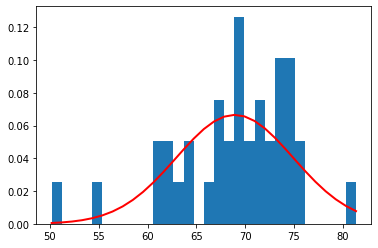

Sample mean: 68.9395411904698


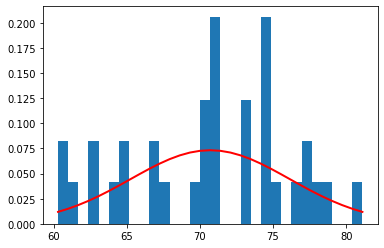

Sample mean: 70.70761577653218


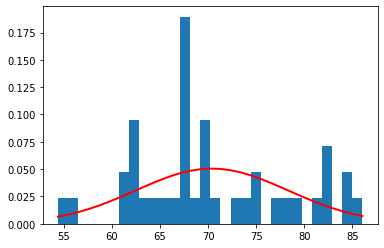

Sample mean: 70.39084001092446


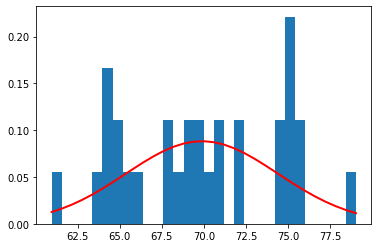

Sample mean: 69.88423546640585


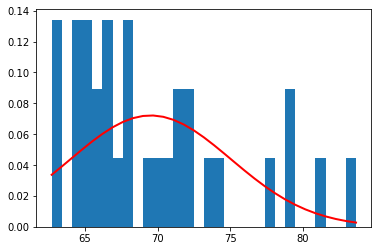

Sample mean: 69.52736217528376


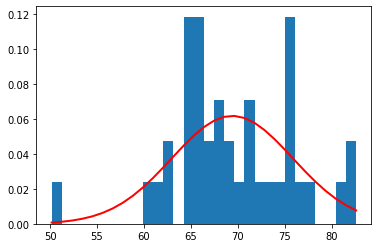

Sample mean: 69.40552734740643


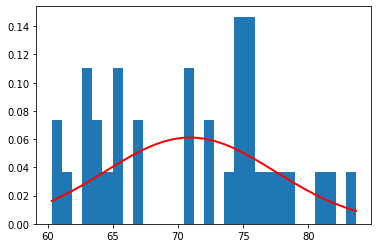

Sample mean: 70.93580057788576


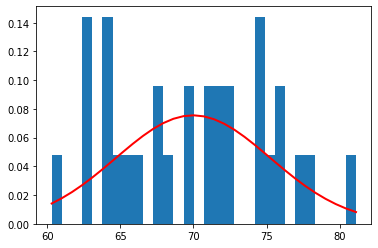

Sample mean: 69.97675920014169


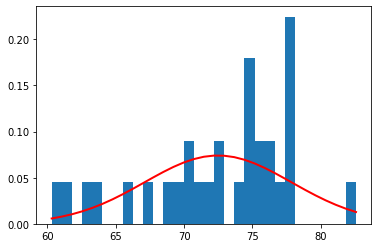

Sample mean: 72.47851575067779


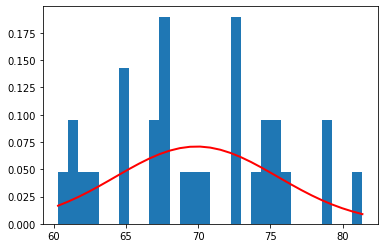

Sample mean: 69.8999173699879


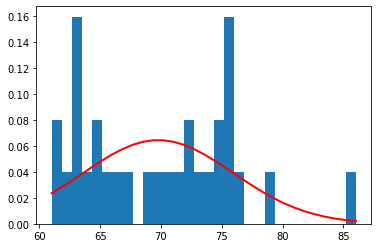

Sample mean: 69.77132371247036


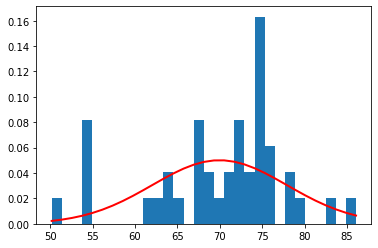

Sample mean: 69.9615845490465


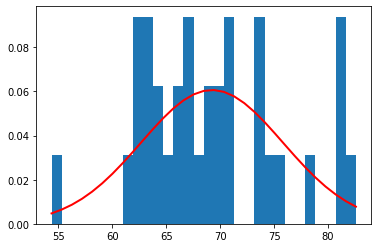

Sample mean: 69.24617382222586


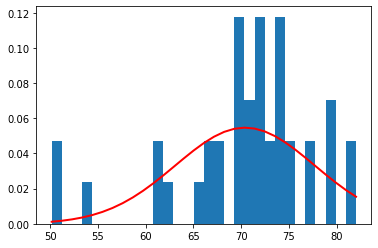

Sample mean: 70.40035673022517


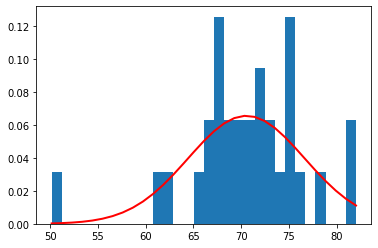

Sample mean: 70.54080073497352


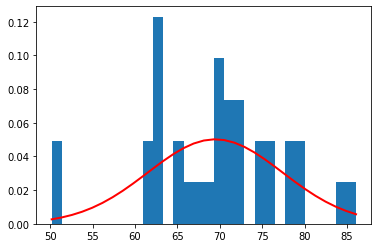

Sample mean: 69.45191837256631


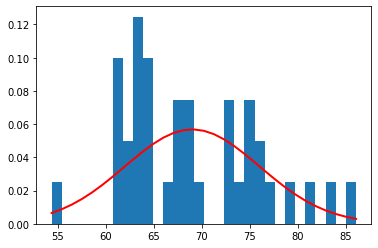

Sample mean: 69.00566372450912


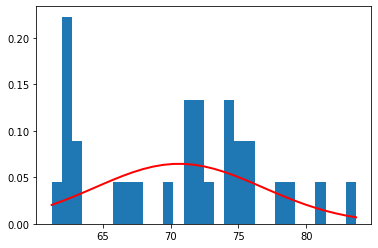

Sample mean: 70.624044947841


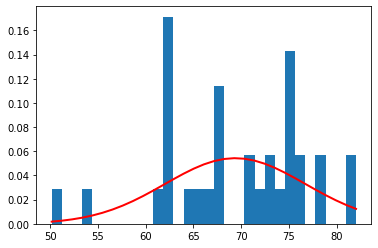

Sample mean: 69.37284366932192


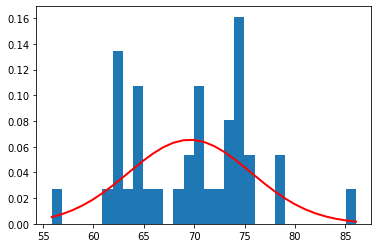

Sample mean: 69.56295502152989


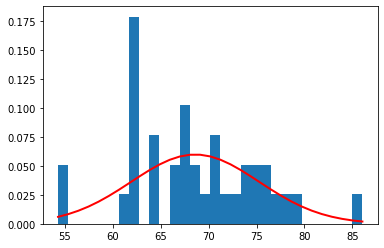

Sample mean: 68.59028852559052


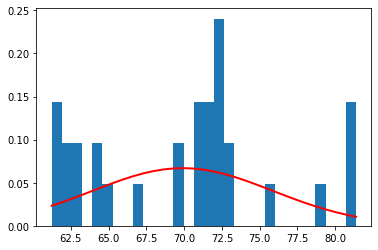

Sample mean: 69.90400074313658


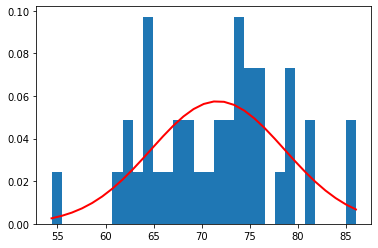

Sample mean: 71.67826999577751


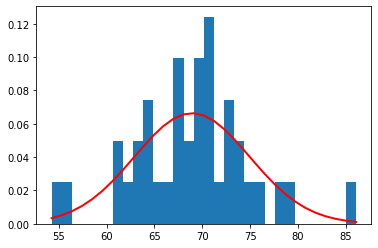

Sample mean: 68.92858460034813


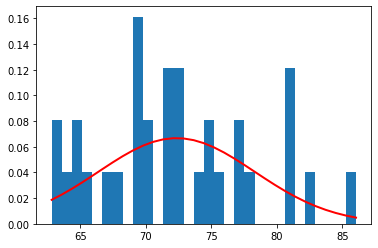

Sample mean: 72.34504514959713


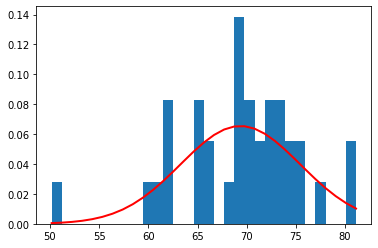

Sample mean: 69.35563654595522


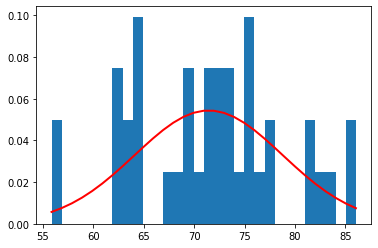

Sample mean: 71.44136654153765


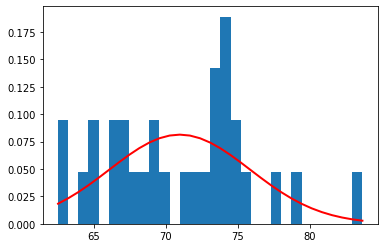

Sample mean: 70.96045413813746


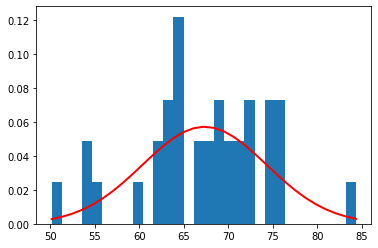

Sample mean: 67.3384709500096


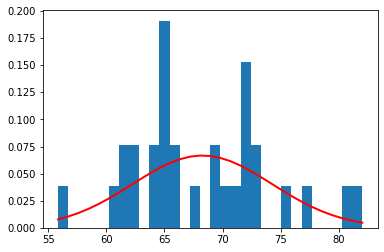

Sample mean: 68.2558260665083


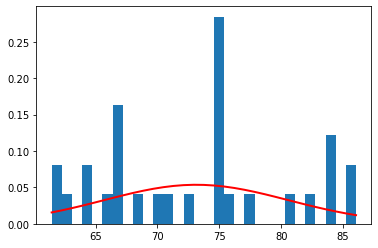

Sample mean: 73.13669406646194


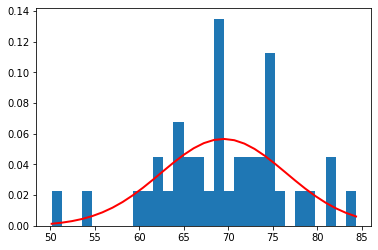

Sample mean: 69.4718745888275


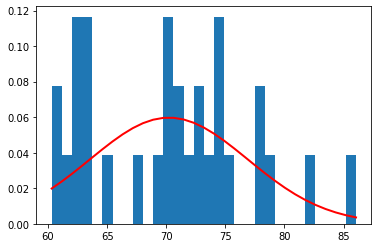

Sample mean: 70.21883549357926


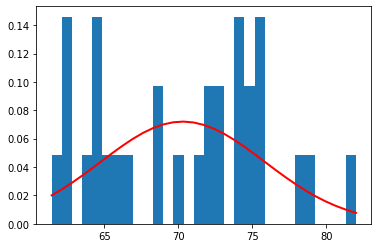

Sample mean: 70.3089582784121


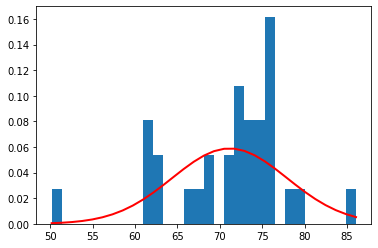

Sample mean: 71.14568742917383


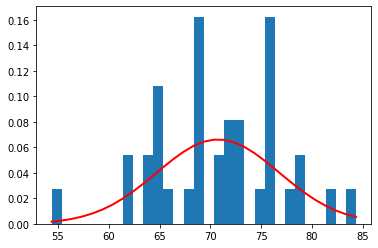

Sample mean: 70.7569931559511


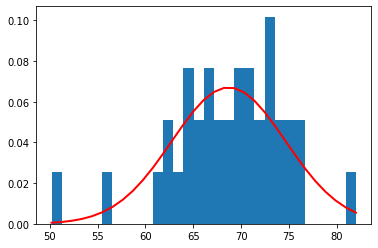

Sample mean: 68.70582108871959


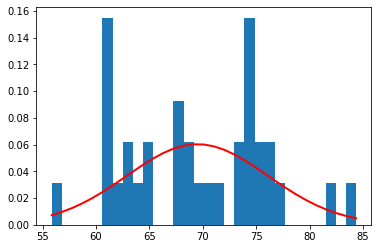

Sample mean: 69.49332763531021


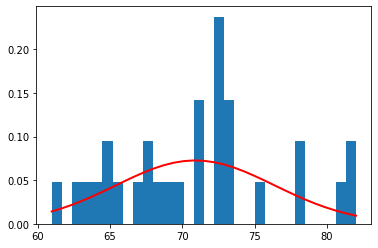

Sample mean: 70.88974951098962


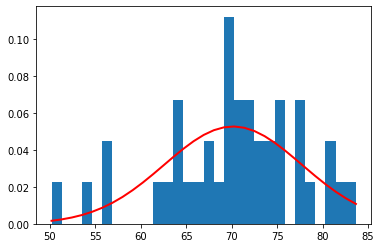

Sample mean: 70.15340404020904


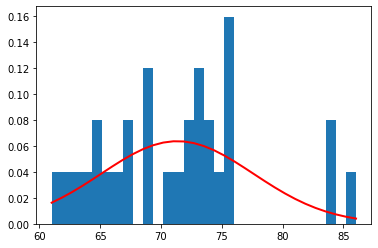

Sample mean: 71.34222940698989


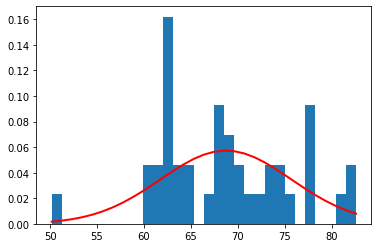

Sample mean: 68.71958140268869


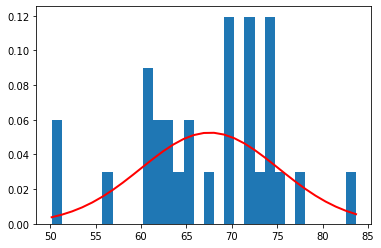

Sample mean: 67.57518104347581


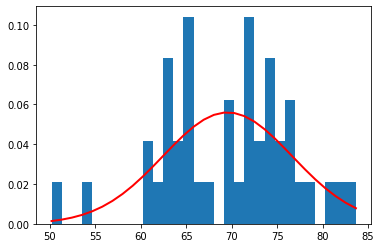

Sample mean: 69.54405032300915


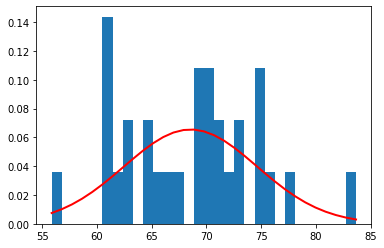

Sample mean: 68.54333991531175


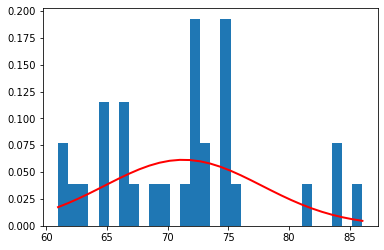

Sample mean: 71.27801117299902


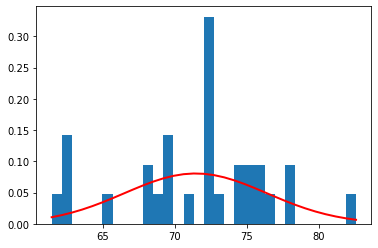

Sample mean: 71.44299957964192


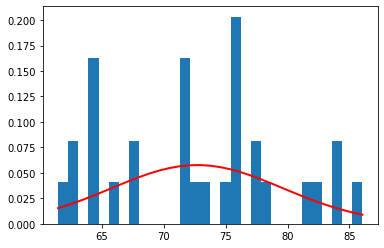

Sample mean: 72.7013214956189


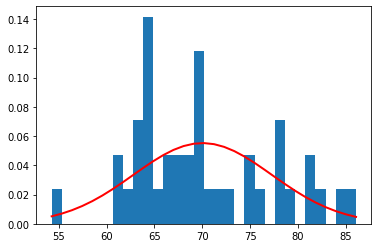

Sample mean: 70.03304630672112


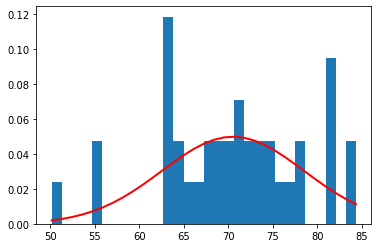

Sample mean: 70.53008578765426


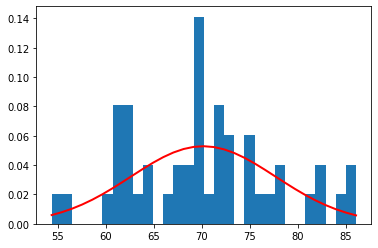

Sample mean: 70.1523103686948


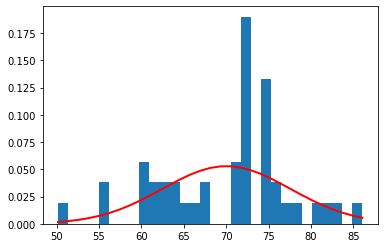

Sample mean: 70.01766282845601


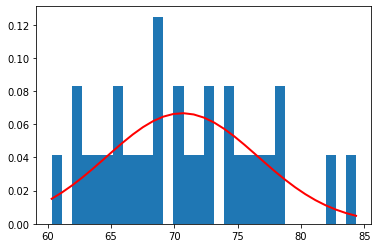

Sample mean: 70.62620992342262


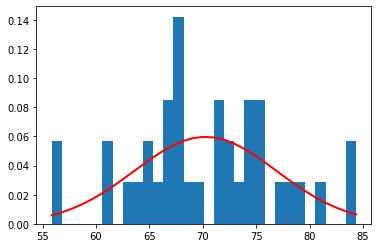

Sample mean: 70.24564376856871


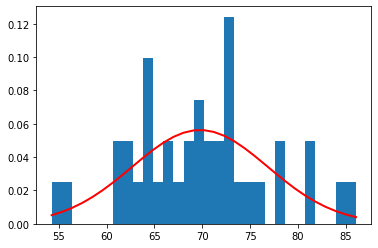

Sample mean: 69.7586131688378


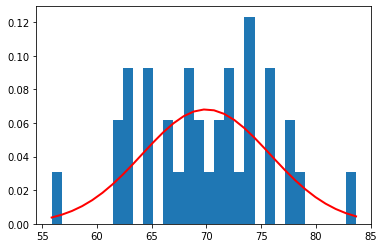

Sample mean: 69.9648514854102


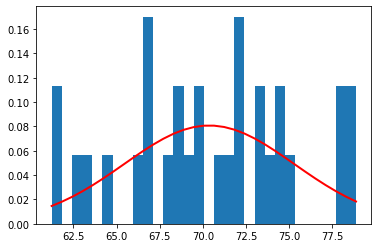

Sample mean: 70.36107408025146


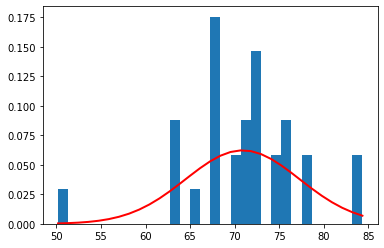

Sample mean: 70.89529778503008


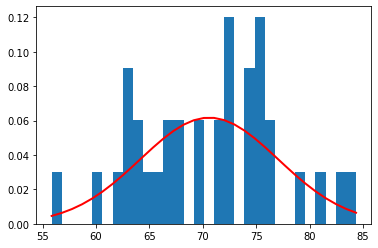

Sample mean: 70.60044821394544


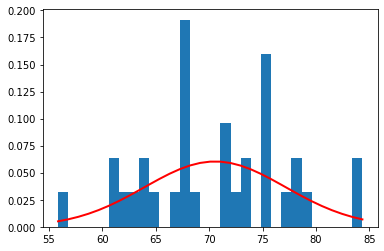

Sample mean: 70.55451269681332


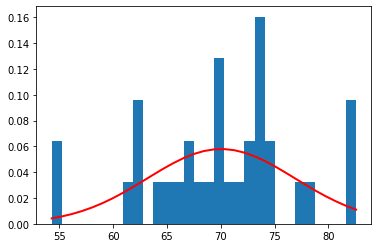

Sample mean: 70.03529711649259


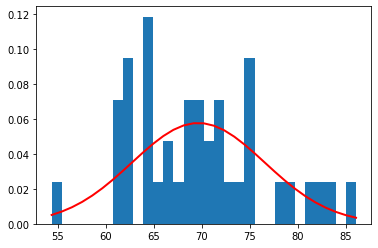

Sample mean: 69.64600324642947


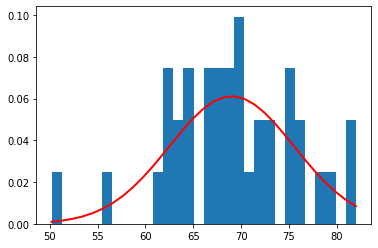

Sample mean: 69.02028300244973


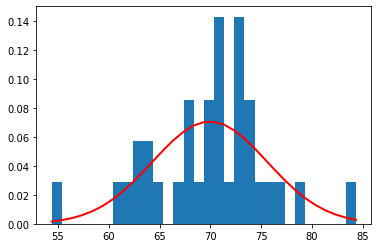

Sample mean: 69.95171995659824


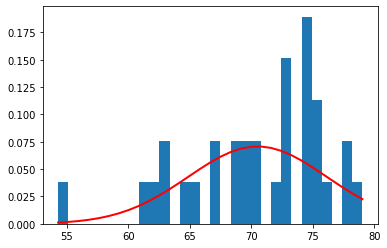

Sample mean: 70.5032810836095


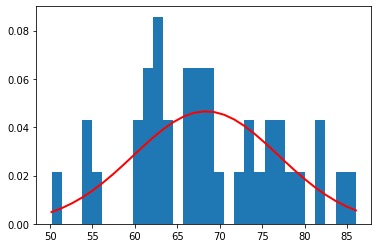

Sample mean: 68.3835003126197


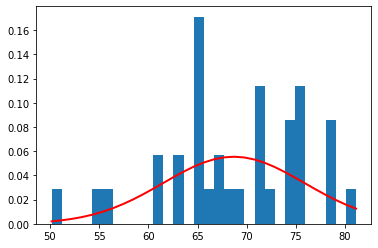

Sample mean: 68.69387971448914


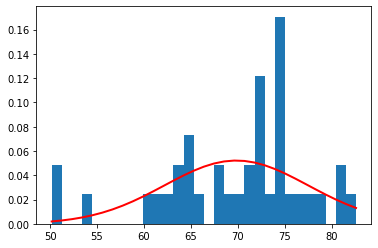

Sample mean: 69.83168579263814


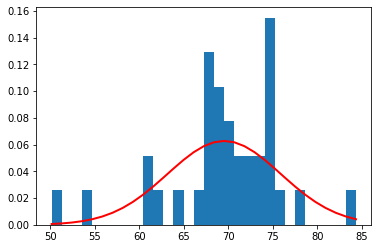

Sample mean: 69.5366661342305


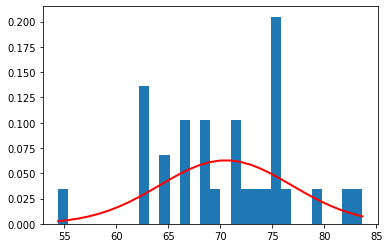

Sample mean: 70.51091843241782


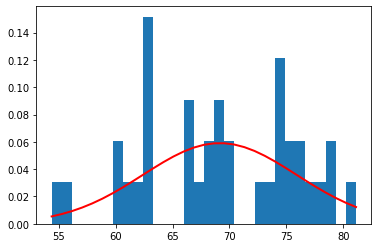

Sample mean: 69.14536495723488


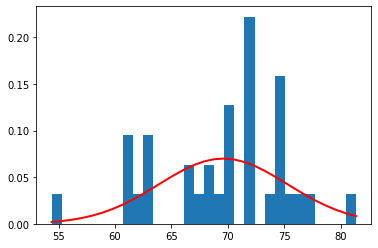

Sample mean: 69.59683017574872


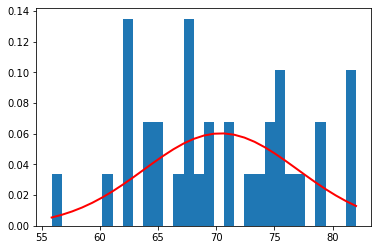

Sample mean: 70.38939667930343


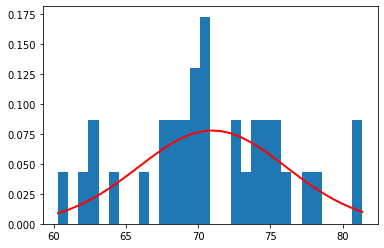

Sample mean: 70.98943566434068


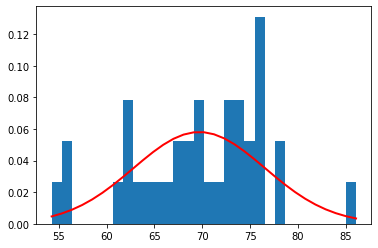

Sample mean: 69.68354716140013


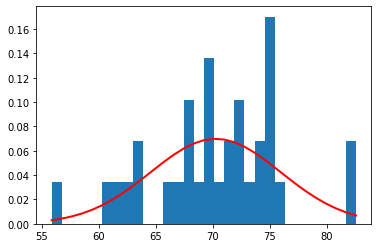

Sample mean: 70.25471879711108


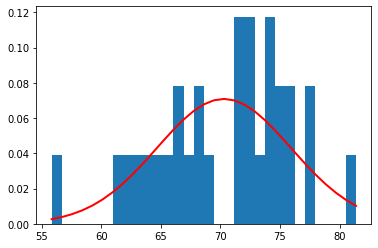

Sample mean: 70.29905840422767


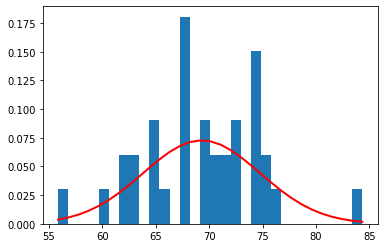

Sample mean: 69.29315014130638


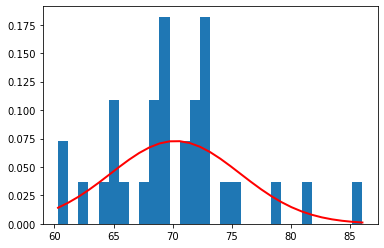

Sample mean: 70.23329623535804


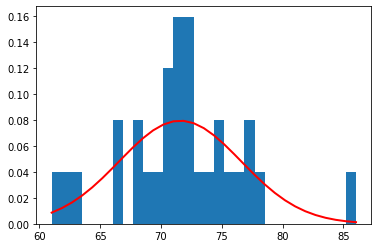

Sample mean: 71.57902442530671


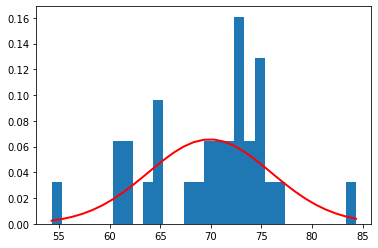

Sample mean: 69.88518071695565


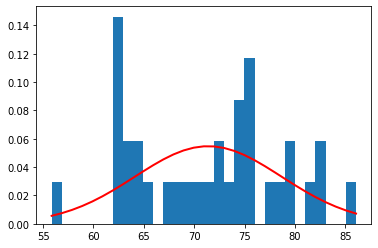

Sample mean: 71.38734122378511


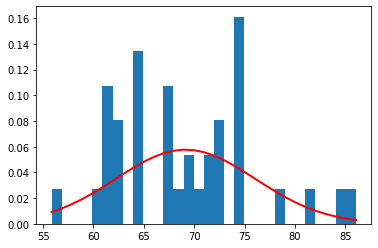

Sample mean: 69.13084617851382


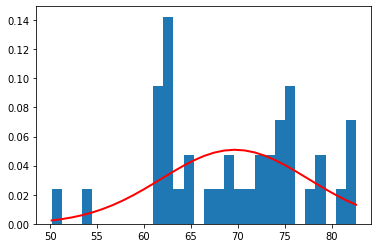

Sample mean: 69.6662526220134


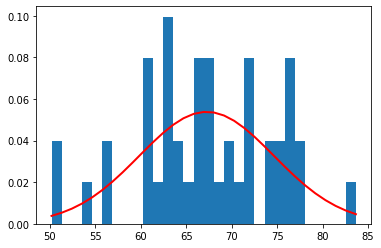

Sample mean: 67.24168458120636


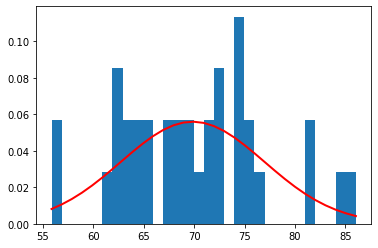

Sample mean: 69.85684298576668


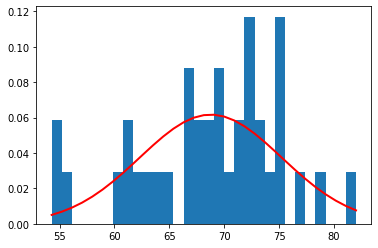

Sample mean: 68.77062793512138


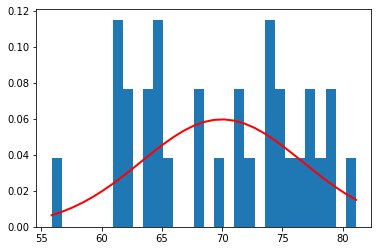

Sample mean: 69.9760378351078


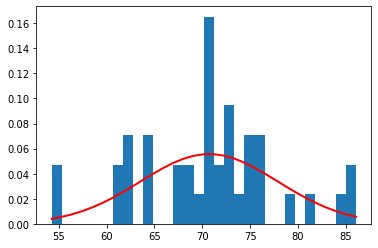

Sample mean: 70.71433280018738


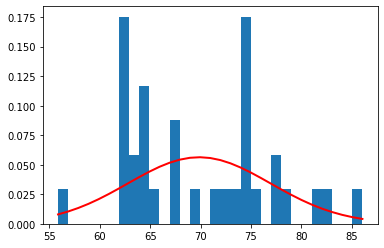

Sample mean: 69.8605583070563


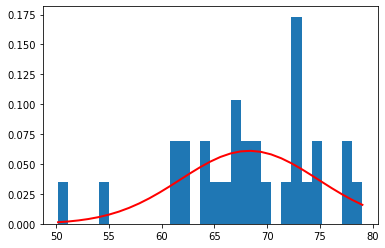

Sample mean: 68.3094101700787


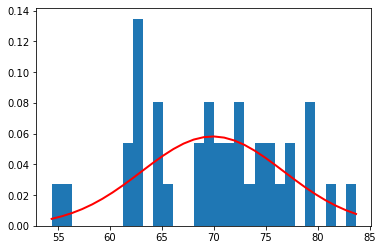

Sample mean: 69.87802693561264


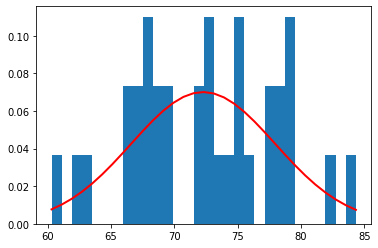

Sample mean: 72.28251163203517


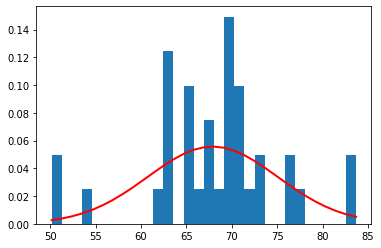

Sample mean: 67.89580005706621
Mean of sample_means: 70.0061151005329
STD of sample_means: 1.0779036250280962
Minimum sample_means: 67.24168458120636
Maximum sample_means: 73.13669406646194
Mean of sample_sizes: 34.57
STD of sample_sizes: 4.047851281853127
Minimum sample_sizes: 30.0
Maximum sample_sizes: 47.0
Mean of sample_stds: 6.465809303861319
STD of sample_stds: 0.8127668646223897
Minimum sample_stds: 4.52055003262051
Maximum sample_stds: 8.563652847788735
Total samples falling within the range specified by the error: 100


In [6]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 100, 3.5, Confidence.NINETIES, None, verbose=2)

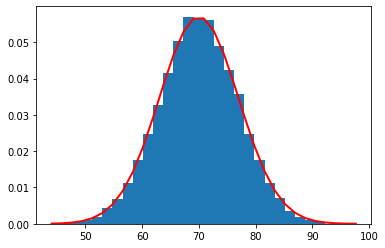

Mean of population: 69.97559809159479
STD of population: 6.949656968656931
Minimum population: 44.021007744254334
Maximum population: 97.68564184486146
Mean of sample_means: 69.84153808795274
STD of sample_means: 0.8222774861955843
Minimum sample_means: 67.50487001900258
Maximum sample_means: 71.73705996306933
Mean of sample_sizes: 75.58
STD of sample_sizes: 4.2992557495454955
Minimum sample_sizes: 70.0
Maximum sample_sizes: 87.0
Mean of sample_stds: 6.885236808817297
STD of sample_stds: 0.5342469516491597
Minimum sample_stds: 5.832159980130454
Maximum sample_stds: 8.213963504082757
Total samples falling within the range specified by the error: 100


In [7]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 10000, 3.5, Confidence.NINETIES, None)

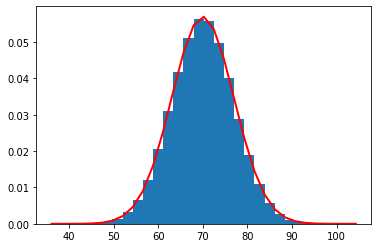

Mean of population: 69.99709698816162
STD of population: 6.994993245661217
Minimum population: 36.09498216390016
Maximum population: 104.31779429644618
Mean of sample_means: 70.025642502427
STD of sample_means: 0.6116698943689252
Minimum sample_means: 68.14175101783151
Maximum sample_means: 71.83769536857973
Mean of sample_sizes: 115.85
STD of sample_sizes: 5.158245825859796
Minimum sample_sizes: 110.0
Maximum sample_sizes: 131.0
Mean of sample_stds: 6.906973970018658
STD of sample_stds: 0.4455764609982343
Minimum sample_stds: 5.952932100201198
Maximum sample_stds: 8.087368263161343
Total samples falling within the range specified by the error: 100


In [8]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 1000000, 3.5, Confidence.NINETIES, None)

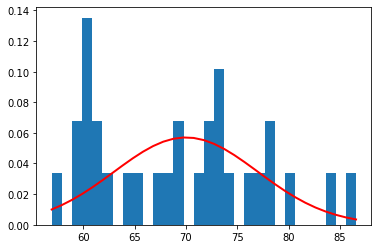

Mean of population: 69.28136659893184
STD of population: 7.922730795501666
Minimum population: 56.93703915424312
Maximum population: 86.54499697058937
Mean of sample_means: 69.49810238060822
STD of sample_means: 2.036368661206361
Minimum sample_means: 65.64329382524832
Maximum sample_means: 74.26680465477929
Mean of sample_sizes: 15.0
STD of sample_sizes: 0.0
Minimum sample_sizes: 15.0
Maximum sample_sizes: 15.0
Mean of sample_stds: 7.612635189517045
STD of sample_stds: 1.136729075633189
Minimum sample_stds: 4.650786248478113
Maximum sample_stds: 10.489789378139035
Total samples falling within the range specified by the error: 65


In [9]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 30, 2, Confidence.EIGHTIES, None)

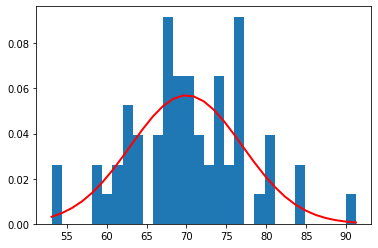

Mean of population: 70.31494567910683
STD of population: 7.289102831324681
Minimum population: 53.10806133038547
Maximum population: 91.22100569078576
Mean of sample_means: 70.35599207707152
STD of sample_means: 1.4289433403515601
Minimum sample_means: 66.64712284732833
Maximum sample_means: 73.95165409541664
Mean of sample_sizes: 28.6
STD of sample_sizes: 2.9698484809834995
Minimum sample_sizes: 16.0
Maximum sample_sizes: 30.0
Mean of sample_stds: 7.068865590998082
STD of sample_stds: 1.0600594405038826
Minimum sample_stds: 4.233582803078751
Maximum sample_stds: 10.22162304765049
Total samples falling within the range specified by the error: 84


In [10]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 60, 2, Confidence.EIGHTIES, None)

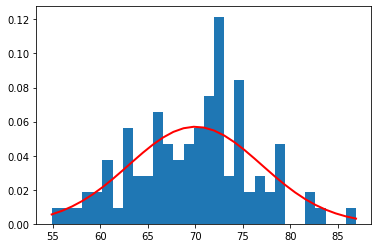

Mean of population: 69.86219339195065
STD of population: 6.237560503151829
Minimum population: 54.86367581788389
Maximum population: 86.93987219987604
Mean of sample_means: 69.90954788235807
STD of sample_means: 0.9273542823340817
Minimum sample_means: 67.47812199428066
Maximum sample_means: 72.10835637140295
Mean of sample_sizes: 49.04
STD of sample_sizes: 2.7853904573685897
Minimum sample_sizes: 30.0
Maximum sample_sizes: 50.0
Mean of sample_stds: 6.127189810420686
STD of sample_stds: 0.635507034719813
Minimum sample_stds: 4.232428872220191
Maximum sample_stds: 7.839927913556731
Total samples falling within the range specified by the error: 95


In [11]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 100, 2, Confidence.NINETIES, None)

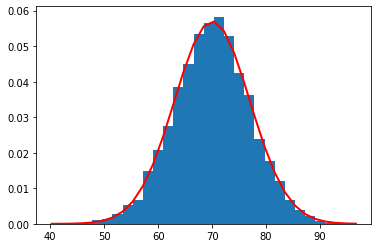

Mean of population: 69.96094234024815
STD of population: 7.01524441870109
Minimum population: 40.24114730015053
Maximum population: 96.64821600418236
Mean of sample_means: 69.92950924753323
STD of sample_means: 0.6194246490319664
Minimum sample_means: 68.34810401845688
Maximum sample_means: 71.50825407620134
Mean of sample_sizes: 109.07
STD of sample_sizes: 9.837941857929433
Minimum sample_sizes: 85.0
Maximum sample_sizes: 138.0
Mean of sample_stds: 6.981553202776789
STD of sample_stds: 0.5391264211989643
Minimum sample_stds: 5.64677849342444
Maximum sample_stds: 8.275023076823798
Total samples falling within the range specified by the error: 100


In [12]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 10000, 2, Confidence.NINETIES, None)

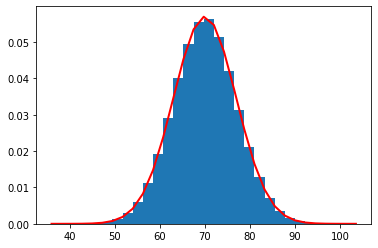

Mean of population: 69.99352865226189
STD of population: 7.010416420673044
Minimum population: 35.94752127969116
Maximum population: 103.56986866645525
Mean of sample_means: 70.00493835961316
STD of sample_means: 0.60754362242077
Minimum sample_means: 68.72014553007523
Maximum sample_means: 71.30096921075966
Mean of sample_sizes: 147.88
STD of sample_sizes: 10.230620704532058
Minimum sample_sizes: 122.0
Maximum sample_sizes: 169.0
Mean of sample_stds: 6.9238709715460915
STD of sample_stds: 0.38884503801096154
Minimum sample_stds: 5.94526007606801
Maximum sample_stds: 7.978647824830137
Total samples falling within the range specified by the error: 100


In [13]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 1000000, 2, Confidence.NINETIES, None)

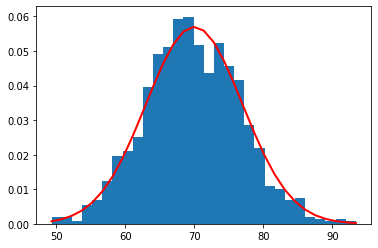

Mean of population: 69.80827586187762
STD of population: 6.897390674848957
Minimum population: 49.347293068388595
Maximum population: 93.40764450102523
Mean of sample_means: 69.80358553762089
STD of sample_means: 0.47190346655486665
Minimum sample_means: 67.85031322059518
Maximum sample_means: 71.00956288398527
Mean of sample_sizes: 200.0
STD of sample_sizes: 0.0
Minimum sample_sizes: 200.0
Maximum sample_sizes: 200.0
Mean of sample_stds: 6.825084446011026
STD of sample_stds: 0.3211914955785036
Minimum sample_stds: 6.16101591702814
Maximum sample_stds: 7.954652680898955
Total samples falling within the range specified by the error: 97


In [14]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 1000, 1, Confidence.HIGHNINETIES, None)

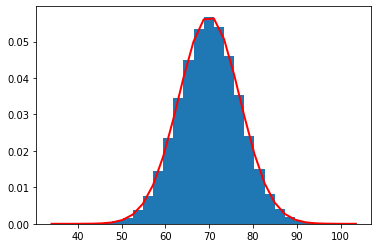

Mean of population: 70.00350090458956
STD of population: 6.996950197478643
Minimum population: 33.988673093156486
Maximum population: 103.51428815136973
Mean of sample_means: 70.02536073766791
STD of sample_means: 0.4763657221896819
Minimum sample_means: 68.60023658904751
Maximum sample_means: 71.44829580183256
Mean of sample_sizes: 200.0
STD of sample_sizes: 0.0
Minimum sample_sizes: 200.0
Maximum sample_sizes: 200.0
Mean of sample_stds: 6.9504439521617964
STD of sample_stds: 0.3678488228812315
Minimum sample_stds: 5.931814688277442
Maximum sample_stds: 7.934875791922326
Total samples falling within the range specified by the error: 96


In [15]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 1000000, 1, Confidence.HIGHNINETIES, None)

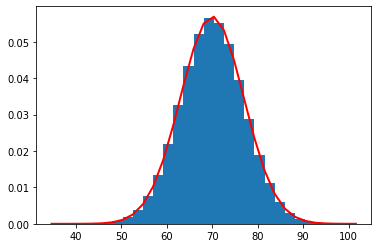

Mean of population: 70.01042475992433
STD of population: 7.00155523695893
Minimum population: 34.69512071086223
Maximum population: 101.62487071972485
Mean of sample_means: 70.01744674594792
STD of sample_means: 0.3684993266722457
Minimum sample_means: 69.19457268137074
Maximum sample_means: 70.92694323145788
Mean of sample_sizes: 300.0
STD of sample_sizes: 0.0
Minimum sample_sizes: 300.0
Maximum sample_sizes: 300.0
Mean of sample_stds: 6.981524424494342
STD of sample_stds: 0.31385340278665735
Minimum sample_stds: 5.962050387751081
Maximum sample_stds: 7.837092077423849
Total samples falling within the range specified by the error: 100


In [16]:
sample_means, sample_sizes, sample_stds = test_100_samples(mean, std, 1000000, 1, Confidence.HIGHNINETIES, 300)